# OPFB Exploration
The purpose of this notebook is to show how to design a filter for an oversampled polyphase filter bank channelizer (OPFB) and how to implement an OPFB in Python and visualize the output. This notebook can help demystify OPFB design and operation.

Author: Jenny Smith, Ph.D. Candidate, UCSB Physics

Date: Friday, June 24th, 2022

Last Updated: 08/23/24

# Imports

In [1]:
import numpy as np
import scipy.signal as sci
import matplotlib.pyplot as plt
from fractions import Fraction

## OPFB Parameters

In [2]:
M = 4096      # Number of OPFB Channels
D = 2048      # Number of new samples entering the channelizer each cycle
OS = M/D      # Oversampling factor
taps = 4      # Number of filter taps per polyphase branch
fs = 4.096e9  # ADC Sample Rate

## Filter Design

In [3]:
cutoff = 2/M # Nominally this should be OS/M but you can fine-tune for different applications
h = sci.firwin(M*taps,cutoff,window="hamming") # Can explore different shapes here

### Plot Prototype Filter Design

/tmp/ipykernel_16326/1655656650.py:10: RuntimeWarning: divide by zero encountered in log10
  axes[1].plot(np.linspace(0,fs/2,h.size//2+1)*1e-6,20*np.log10(np.abs((np.fft.rfft(h)))))


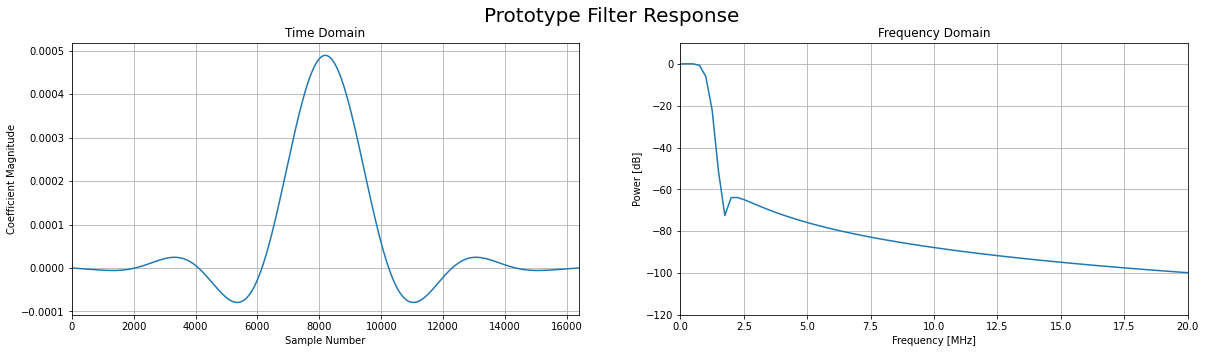

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(20,5), gridspec_kw={'width_ratios':[1,1]})
fig.suptitle('Prototype Filter Response', fontsize=20)
axes[0].title.set_text("Time Domain")
axes[0].plot(h)
axes[0].grid()
axes[0].set_xlim([0,h.size])
axes[0].set_xlabel("Sample Number")
axes[0].set_ylabel("Coefficient Magnitude")
axes[1].title.set_text("Frequency Domain")
axes[1].plot(np.linspace(0,fs/2,h.size//2+1)*1e-6,20*np.log10(np.abs((np.fft.rfft(h)))))
axes[1].grid()
axes[1].set_xlabel("Frequency [MHz]")
axes[1].set_xlim([0,10*(OS*fs/M)*1e-6])
axes[1].set_ylim([-120,10])
axes[1].set_ylabel("Power [dB]");

### Expected Channelizer Performance

In [5]:
hfres = int(1e5) # Filter Analysis Frequency resolution
hfreq_ax = fs*(np.linspace(-hfres/2,hfres/2,hfres)/hfres); # Filter Analysis Frequency Axis

In [6]:
# Compute Sub Bands
h1=h*np.exp(1j*2*np.pi*np.linspace(0,h.size, h.size)*1/M);
h2=h*np.exp(1j*2*np.pi*np.linspace(0,h.size, h.size)*2/M);

# Compute Sub Band Responses
subband_0 = np.fft.fftshift(20*np.log10(np.abs(np.fft.fft(h,n=hfres))))
subband_1 = np.fft.fftshift(20*np.log10(np.abs(np.fft.fft(h1,n=hfres))))
subband_2 = np.fft.fftshift(20*np.log10(np.abs(np.fft.fft(h2,n=hfres))))

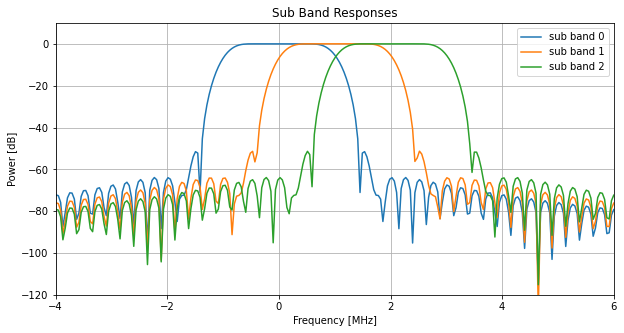

In [7]:
plt.figure(figsize=(10,5))
plt.plot(hfreq_ax*1e-6,subband_0)
plt.plot(hfreq_ax*1e-6,subband_1)
plt.plot(hfreq_ax*1e-6,subband_2)
plt.xlim([-2*(OS*fs/M)*1e-6,3*(OS*fs/M)*1e-6])
plt.ylim([-120,10])
plt.grid()
plt.legend(['sub band 0','sub band 1','sub band 2']);
plt.title('Sub Band Responses')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power [dB]');

In [8]:
# Compute Sub-Band Images
h_image = h*np.exp(1j*2*np.pi*np.linspace(0,h.size, h.size)*OS/M);
image_0 = np.fft.fftshift(20*np.log10(np.abs(np.fft.fft(h_image,n=hfres))))

# Filter Parameters
cutoff_db = 3 # Attenuation which defines the edge of the passband 
band_edge = np.where(subband_0[subband_0.size//2:]<-cutoff_db)[0][0]+subband_0.size//2

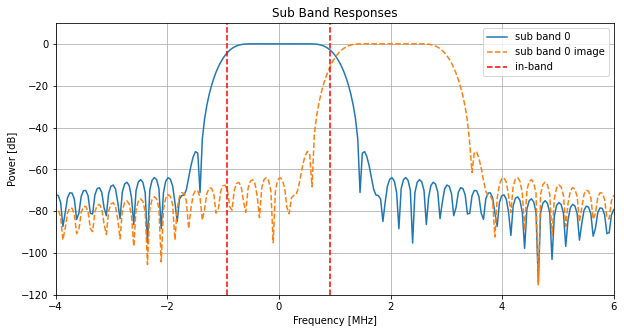

In [9]:
plt.figure(figsize=(10,5))
plt.plot(hfreq_ax*1e-6,subband_0)
plt.plot(hfreq_ax*1e-6,image_0, ls='--')
plt.xlim([-2*(OS*fs/M)*1e-6,3*(OS*fs/M)*1e-6])
plt.ylim([-120,10])
plt.axvline(x=hfreq_ax[band_edge]*1e-6, color='r', ls='--')
plt.axvline(x=-hfreq_ax[band_edge]*1e-6, color='r', ls='--')
plt.grid()
plt.legend(['sub band 0','sub band 0 image', 'in-band']);
plt.title('Sub Band Responses')
plt.xlabel('Frequency [MHz]');
plt.ylabel('Power [dB]');

# OPFB
## Generate Test Data

In [10]:
ofres = 1024 # OPFB Analysis Frequency resolution
N = int(M*ofres/OS) # Input Data Length
t = np.linspace(0,N-1,N)/fs

frequencies = np.array([200.5e6,-800e6]) # unit is Hz
amplitudes = np.ones_like(frequencies)/frequencies.size

snr = 10 # signal-to-noise ratio

a_noise = 10**((20*np.log10(1/np.sqrt(2)) - snr)/10);
noise = np.sqrt(a_noise)*(np.random.normal(size=N) + 1j*np.random.normal(size=N))
raw_data = np.zeros(N, dtype=np.complex128)+noise

for f in range(len(frequencies)):
    sinewave = amplitudes[f]*np.exp(2*np.pi*1j*frequencies[f]*t)
    raw_data+=sinewave

### Visualize Input Test Data

In [11]:
fft_in = 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(raw_data))))
ofreq_ax = np.linspace(-fs/2,fs/2,N) # OPFB Analysis Frequency Axis

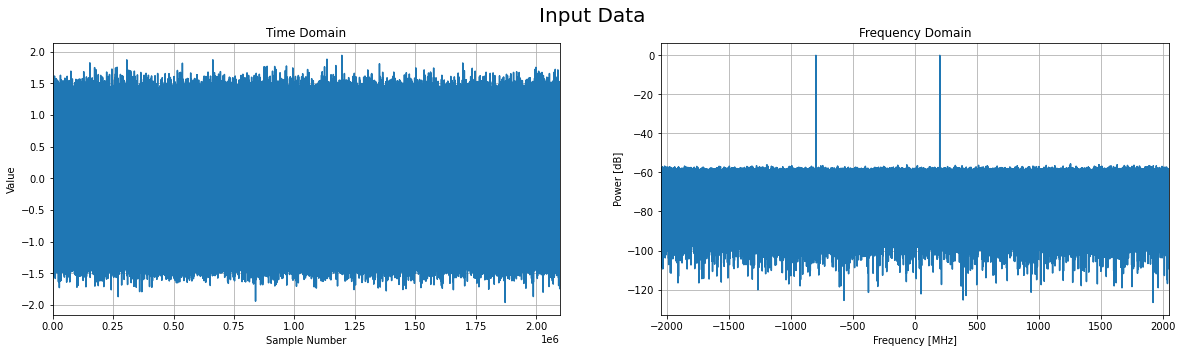

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20,5), gridspec_kw={'width_ratios':[1,1]})
fig.suptitle('Input Data', fontsize=20)
axes[0].title.set_text("Time Domain")
axes[0].plot(raw_data.real)
axes[0].set_xlim([0,raw_data.shape[0]])
axes[0].grid()
axes[0].set_xlabel("Sample Number")
axes[0].set_ylabel("Value")
axes[1].title.set_text("Frequency Domain")
axes[1].plot(ofreq_ax*1e-6,fft_in-fft_in.max())
axes[1].grid()
axes[1].set_xlabel("Frequency [MHz]")
axes[1].set_xlim([-fs/2*1e-6,fs/2*1e-6])
axes[1].set_ylabel("Power [dB]");

## Run the OPFB

In [13]:
# Prepend the data with the appropriate number of zeros to fill the filter 
in_data = np.insert(raw_data, 0, np.zeros(h.size-D))

# Compute Shift States
n_shift_states = Fraction(M,D).numerator
shift_states = (np.linspace(0,n_shift_states-1,n_shift_states)*D%M).astype(int)
shift_cnt = 0

#Prepare Output
x = 0
out_data = np.zeros((M,ofres),dtype=np.complex128)

In [14]:
# Do the OPFB
for cycle in range(0,ofres):
    filt_mult = in_data[x:M*taps+x]*h # move data through filter D samples at a time and multiply by filter coeffs
    filt_out = np.sum(filt_mult.reshape(taps,M).transpose(),axis=1) # sum along polyphase branches
    reordered_fft = np.fft.fft(np.roll(filt_out, shift_states[shift_cnt])) # reorder the data and take the fft
    out_data[:,cycle]=reordered_fft # store data in output array
    if shift_cnt==shift_states.size-1: # manage shift state machine
        shift_cnt = 0
    else:
        shift_cnt+=1
    x+=D

## Visualize OPFB Output
The OPFB outputs a timeseries `ofres` long for all `M` channels. To analyize the result we will take the `ofres`-point FFT of each output channel and plot the overlapping bin spectra. The OPFB has already applied one FFT to do the channelization so the output channels are in order: DC channel (row 0), followed by increasingly positive frequencies, then the $M/2^{th}$ bin (the Nyquist bin which is common to both positive and negative frequencies but is by convention assigned the most negative frequency see explanation [here](https://www.gaussianwaves.com/2015/11/interpreting-fft-results-complex-dft-frequency-bins-and-fftshift/)), followed by the negative frequencies increasing back towards 0 Hz. The resulting output is therefore reordered twice using `np.fft.fftshift`, once to re-order the OPFB channels, and once to reorder the FFT of each channel's time series.

In [15]:
# Reorder output so frequencies are ordered negative --> 0 --> positive
out_data_spectrum = np.fft.fftshift(20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(out_data, axis=1), axes=1))),axes=0)

In [16]:
# Compute frequency axis for output bins
bin_centers = (fs/M)*np.linspace(-M/2, M/2-1, M)
bin_width = (fs/M)*OS
base_bin_freq = np.linspace(-bin_width/2, bin_width/2-1, ofres)

### OPFB Output
The `left_snip` parameter is there to remove the Nyquist bin from each output channel if desired. If you place a tone in an exact bin center, I recommend keeping `left_snip=1` because otherwise you will see your bin-centered tone appearing at the far left of the adjacent bin because of the convention to assign the Nyquist bin to the most negative frequency. It may look alarming and cause you to wonder if the channelizer is working properly but that is expected. You can experiment with this youself by setting `left_snip=0` which will not remove the Nyquist bin.

### Tone 0 Bin Adjacent Channels

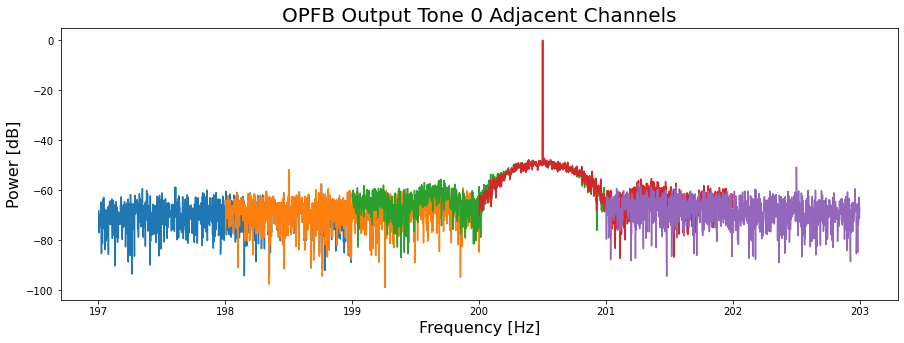

In [17]:
plt.figure(figsize=(15,5))
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Power [dB]', fontsize=16)
plt.title('OPFB Output Tone 0 Adjacent Channels', fontsize=20)
tone0_bin = np.round(frequencies[0] / (fs/M)).astype(int) + int(M/2)
bins=range(tone0_bin-2,tone0_bin+3)
left_snip=1
for nbin in bins:
    plt.plot((nbin-M/2)+base_bin_freq[left_snip:]*1e-6,out_data_spectrum[nbin,left_snip:]-out_data_spectrum.max())

### All Bins
This may take a minute or two to execute

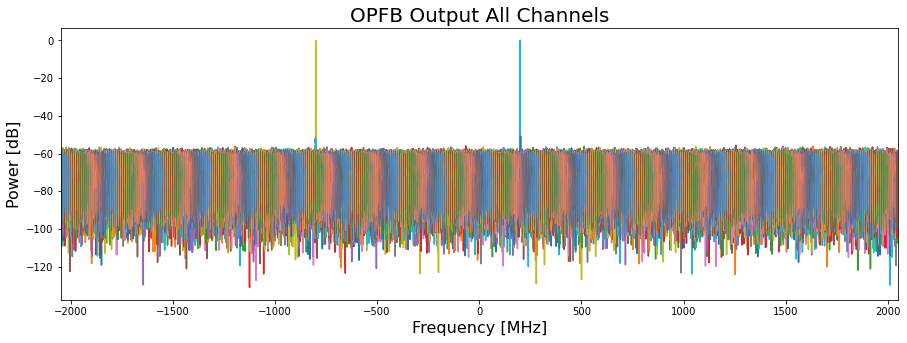

In [18]:
plt.figure(figsize=(15,5))
plt.xlabel('Frequency [MHz]', fontsize=16)
plt.ylabel('Power [dB]', fontsize=16)
plt.title('OPFB Output All Channels', fontsize=20)
plt.xlim([-fs/2*1e-6,fs/2*1e-6])

bins=range(0,M)
left_snip=1
for nbin in bins:
    plt.plot((nbin-M/2)+base_bin_freq[left_snip:]*1e-6,out_data_spectrum[nbin,left_snip:]-out_data_spectrum.max())

## Generate Filter COE Files for FPGA

The following code will generate filter `.coe` files in the format expected by [Xilinx FIR cores](https://docs.xilinx.com/v/u/en-US/fir_compiler_ds534). This code assumes the specific 50% overlapped, 16-lane implementation explained in [this paper](https://ieeexplore.ieee.org/document/9336352) and implemented in [this repo](https://github.com/MazinLab/RFSoC_OPFB/tree/master). The FIR Cores should be configured [like so](https://github.com/MazinLab/RFSoC_OPFB/blob/312afefa982a30a46b4b5f2bde2ce1c0082e028d/bd/opfb_streaming.tcl#L327).

## Quantize to 16-bit int

In [19]:
wordlen = 16
h_max = max(np.abs(h.min()), h.max())
h_norm = h/h_max
h_int = np.round(h_norm*(2**(wordlen-1)-1)).clip(-2**(wordlen), 2**(wordlen-1)-1).astype(np.int16)

## Partition Filter into Multi-Lane PFBs

In [20]:
lanes = 16
channels_per_lane = M//lanes
sixteen_lane_fir = h_int.reshape(channels_per_lane*taps,lanes).T;

pfbs = np.zeros((lanes, channels_per_lane, taps))
for i in range(lanes):
    pfbs[i,::] = sixteen_lane_fir[i,:].reshape(taps, channels_per_lane).T[::,::-1]

## Write COE Files

In [21]:
write_files = False

In [22]:
if write_files:
    for lane in range(lanes):
        with open(f'lane{lane:d}.coe', "w") as f:
                f.write('radix=10;\n')
                f.write('coefdata = \n')
                for idx, val in enumerate(pfbs[lane,::].ravel()):
                    if idx == len(pfbs[lane,::].ravel())-1:
                        f.write('{:1.32f}'.format(val / 2**(wordlen-1))+';')
                    else:
                        f.write('{:1.32f}'.format(val / 2**(wordlen-1))+',\n')     
        f.close()